# Projet Analyse de Données L3 IM2D - Université Paris Dauphine

**Réalisé par : Zakaria YBEGGAZENE**

## **Thème : Création d'un classifier des crimes commis à Chicago**

## Introduction :

Au début, on avait en tête de travailler sur des thématiques avancées comme la détection d'objets en utilisant des réseaux de neuronnes convolutionnels avec du transfer learning. Mais après une bonne réflexion, on s'est rendu compte que ça ne correspondait pas trop aux notions vues dans l'UE PAD, et qu'il serait plus judicieux de choisir un thème dans lequel on pourrait appliquer des modèles linéaires en choisissant notamment un jeu de données numériques plutôt que du dégital.

C'est la raison pour laquelle on a basculé environ une semaine avant le rendu du projet vers la thématique : **classification des crimes commis dans la ville de Chicago**.

On commence par importer quelques bibliothèques de base

In [2]:
%pylab inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


## 1. Importation des données :

Le dataset des crimes commis à Chicago depuis 2001 jusqu'à aujourd'hui (moins les 7 derniers jours) est disponible sur le site : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2 avec des descriptions détaillées de tous les attributs et la possibilité d'effectuer des recherches et des filtres directement sur le site.

On a décidé de télécharger que les crimes depuis 01/01/2015 jusqu'au 31/12/2020 sous format csv. Le fichier .csv est de taille 360Mo et contient plus de 1.5 million d'exemples.

On charge ce dataset dans un `DataFrame pandas` en utilisant la fonction `read_csv()` (veillez à bien mettre le fichier csv dans le même dossier que ce notebook avec le même nom que ci-dessous)

In [3]:
df = pd.read_csv("chicago_crimes_2015_2020.csv")

On affiche les 5 premières lignes du dataframe :

In [4]:
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11227503,JB146383,01/01/2015 12:01:00 AM,061XX S KILBOURN AVE,1751,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,False,True,...,13.0,65.0,17,NaN,NaN,2015,04/12/2019 04:00:15 PM,NaN,NaN,NaN
1,11042867,JA374764,01/01/2015 12:01:00 AM,086XX S MANISTEE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,False,...,7.0,46.0,02,NaN,NaN,2015,08/05/2017 03:50:08 PM,NaN,NaN,NaN
2,11042931,JA374193,01/01/2015 12:01:00 AM,069XX S STEWART AVE,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,6.0,68.0,17,NaN,NaN,2015,08/05/2017 03:50:08 PM,NaN,NaN,NaN
3,11042927,JA374449,01/01/2015 12:01:00 AM,022XX N AVERS AVE,1750,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,RESIDENCE,False,True,...,30.0,22.0,20,NaN,NaN,2015,08/25/2017 03:48:04 PM,NaN,NaN,NaN
4,11042939,JA376124,01/01/2015 12:01:00 AM,049XX S LECLAIRE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,False,False,...,23.0,56.0,02,NaN,NaN,2015,08/05/2017 03:50:08 PM,NaN,NaN,NaN


On appelle `info()` pour avoir plus de détails sur le dataframe notamment le nombre de lignes (1584347) et le nombre de colonnes (22) ainsi que le type de données dans chaque colonne et le nombre de valeurs non nulles

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584347 entries, 0 to 1584346
Data columns (total 22 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ID                    1584347 non-null  int64  
 1   Case Number           1584347 non-null  object 
 2   Date                  1584347 non-null  object 
 3   Block                 1584347 non-null  object 
 4   IUCR                  1584347 non-null  object 
 5   Primary Type          1584347 non-null  object 
 6   Description           1584347 non-null  object 
 7   Location Description  1577736 non-null  object 
 8   Arrest                1584347 non-null  bool   
 9   Domestic              1584347 non-null  bool   
 10  Beat                  1584347 non-null  int64  
 11  District              1584346 non-null  float64
 12  Ward                  1584314 non-null  float64
 13  Community Area        1584346 non-null  float64
 14  FBI Code              1584347 non-

## 2. Exploration et Preprocessing :

Nous allons maintenant explorer nos données et effectuer le preprocessing nécessaire pour préparer le dataset pour l'étape de la modélisation

In [6]:
df['Block'].value_counts()

001XX N STATE ST         5168
0000X W TERMINAL ST      2682
008XX N MICHIGAN AVE     2639
0000X N STATE ST         2045
0000X S STATE ST         1783
                         ... 
016XX W Morse Ave           1
0000X W CHICAGO RIVER       1
013XX W Grand ave           1
007XX W Montrose Ave        1
027XX W 109TH ST            1
Name: Block, Length: 35290, dtype: int64

Un bon nombre de colonnes comme les `ID` des crimes et leur `Case Number` ne sont pas exploitables puisque ce sont des données séquentielles qui servent juste à représenter les crimes.

Le `IUCR` qui est le Illinois Uniform Crime Reporting code est lié à l'attribut `Primary Type`, ces codes et leurs significations se trouvent via ce [lien](https://data.cityofchicago.org/d/c7ck-438e). Le `FBI Code` est aussi un code attribué par le FBI au crime :
>Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.

La `Description` détaillée du crime n'est pas vraiment exploitatble dans notre contexte aussi, pareil pour la date de la mise à jour des informations concernant le crime `Updated On`.

L'attribut `Location` est un tuple de deux éléments qui sont la `Latitude` et la `Longitude` qu'on possède déjà comme deux attributs séparés, on peut alors le supprimer.

`X Coordinate` et `Y Coordinate` représentent l'endroit où le crime s'est passé (tout comme la `Latitude` et la `Longitude`) selon le *State Plane Illinois East NAD 1983 projection*. On peut s'en passer alors puisqu'ils circulent la même information que d'autres attributs.

Enfin, l'attribut `Block` contient l'adresse partielle de l'endroit où le crime s'est déroulé sous forme de chaîne de caractères. L'attribut circule beaucoup de valeurs différentes (même en gardant que les noms des rues, chose qu'on a essayé puis effacé pour ne pas rajouter beaucoup de cellules au notebook), il est donc difficile de les encoder en quelque chose d'exploitatble. Par conséquent, on a décidé de supprimer cet attribut.

Dans la cellule suivante, on supprime les attributs cités ci-dessus. Mais on supprime aussi les lignes qui comptent des valeus nulles avec la fonction `dropna()` puisque la proportion de ces lignes n'est pas grande par rapport à la taille du jeu de données en entier.

On affiche alors le DataFrame obtenu.

In [7]:
df.drop(columns = ['ID', 'Case Number', 'Block', 'IUCR', 'Description', 'FBI Code',
                   'X Coordinate', 'Y Coordinate', 'Updated On', 'Location'], inplace = True)
df.dropna(inplace = True)
df

,Date,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
13,01/01/2015 12:01:00 AM,OBSCENITY,RESIDENCE,False,False,221,2.0,3.0,38.0,2015,41.811212,-87.615663
15,01/01/2015 12:01:00 AM,DECEPTIVE PRACTICE,ATHLETIC CLUB,False,False,1814,18.0,2.0,7.0,2015,41.911151,-87.635982
16,01/01/2015 12:01:00 AM,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,2532,25.0,37.0,25.0,2015,41.902203,-87.760110
17,01/01/2015 12:01:00 AM,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,925,9.0,3.0,37.0,2015,41.814283,-87.633512
18,01/01/2015 12:01:00 AM,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,1512,15.0,29.0,25.0,2015,41.888997,-87.770622
...,...,...,...,...,...,...,...,...,...,...,...,...
1584342,03/29/2021 11:35:00 PM,WEAPONS VIOLATION,STREET,True,False,2533,25.0,37.0,25.0,2021,41.912013,-87.745929
1584343,03/29/2021 11:45:00 PM,BATTERY,STREET,True,True,822,8.0,14.0,63.0,2021,41.795251,-87.709642
1584344,03/29/2021 11:45:00 PM,BATTERY,SIDEWALK,True,False,1831,18.0,42.0,8.0,2021,41.889761,-87.627999
1584345,03/29/2021 11:45:00 PM,BATTERY,APARTMENT,False,True,1931,19.0,32.0,7.0,2021,41.929029,-87.672011


On voit ci-dessous qu'on n'a plus d'enregistrements qui contiennent des valeurs nulles et que nous avons réduit le nombre de colonnes jusqu'à 12.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1558281 entries, 13 to 1584346
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Date                  1558281 non-null  object 
 1   Primary Type          1558281 non-null  object 
 2   Location Description  1558281 non-null  object 
 3   Arrest                1558281 non-null  bool   
 4   Domestic              1558281 non-null  bool   
 5   Beat                  1558281 non-null  int64  
 6   District              1558281 non-null  float64
 7   Ward                  1558281 non-null  float64
 8   Community Area        1558281 non-null  float64
 9   Year                  1558281 non-null  int64  
 10  Latitude              1558281 non-null  float64
 11  Longitude             1558281 non-null  float64
dtypes: bool(2), float64(5), int64(2), object(3)
memory usage: 133.7+ MB


L'attribut `Primary Type` qui représente le type primaire du crime est l'attribut qu'on aimerait prédire avec nos modèles.

Cependant, on remarque ci-dessous avec la fonction `value_counts()` que cet attribut sous format `String` prend un bon nombre de valeurs et que le nombre d'exemples dont on dispose pour chaque type n'est pas du tout équilibré puisque les vols (THEFT) sont beaucoup plus commun que d'autres crimes comme la Traite des êtres humains (HUMAN TRAFFICKING). Et si on veut garder tous ces types comme des classes pour nos modèles ça nous fera beaucoup de classes et avec des nombres d'exemples (d'entraînement et de test) totalement déséquilibrés.

In [9]:
df['Primary Type'].value_counts()

THEFT                                354048
BATTERY                              296870
CRIMINAL DAMAGE                      172321
ASSAULT                              118037
DECEPTIVE PRACTICE                   103402
OTHER OFFENSE                        100414
NARCOTICS                             82613
BURGLARY                              71536
MOTOR VEHICLE THEFT                   63563
ROBBERY                               60653
CRIMINAL TRESPASS                     38033
WEAPONS VIOLATION                     33531
OFFENSE INVOLVING CHILDREN            13163
PUBLIC PEACE VIOLATION                 9769
INTERFERENCE WITH PUBLIC OFFICER       6911
CRIM SEXUAL ASSAULT                    6508
SEX OFFENSE                            6188
PROSTITUTION                           4545
HOMICIDE                               3986
ARSON                                  2845
CRIMINAL SEXUAL ASSAULT                2339
LIQUOR LAW VIOLATION                   1374
STALKING                        

On affiche les **histogrammes** des autres attributs numériques pour voir les tendances qu'il prennent :

-


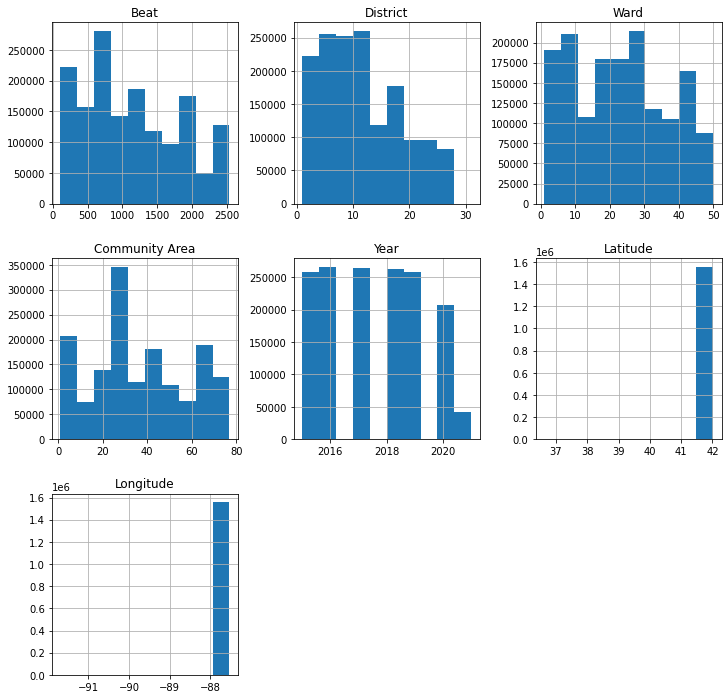

In [10]:
df.hist(figsize=(12,12))
print('-')

Ici on affiche un **barplot** du nombre d'exemples qu'on a pour chaque type de crime (`Primary Type`). On remarque que c'est assez déséquilibré.

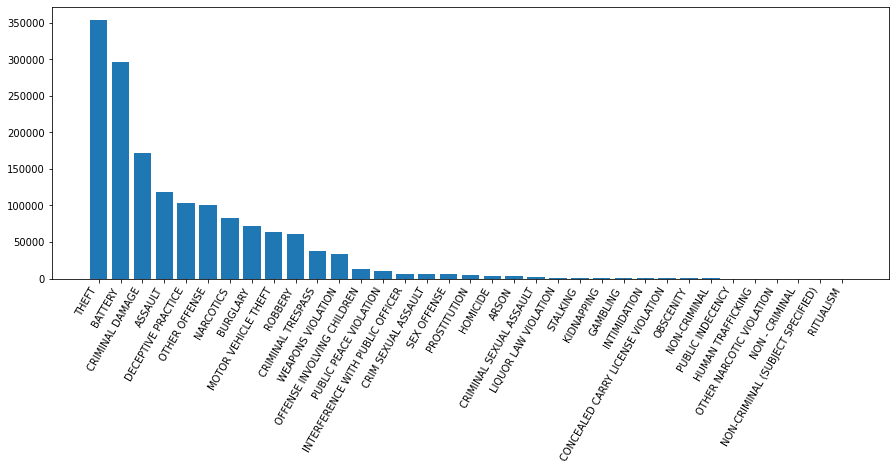

In [11]:
plt.figure(figsize=(15, 5))
plt.bar(df['Primary Type'].value_counts().index.tolist(),df['Primary Type'].value_counts())
plt.xticks(rotation=60, ha="right")
plt.show()

Etant données les difficultés rencontrées pour utiliser `Primary Type` directement pour nos modèles, on a décidé de faire du *Hand Engineering* d'un nouvel attribut qui serait plus équilibré et plus représentatif des crimes.

Après quelques recherches, notamment dans le [*Criminal Code*](https://www.ilga.gov/legislation/ilcs/ilcs3.asp?ChapterID=53&ActID=1876) du *Illinois Compiled Statutes (ILCS)*, on a trouvé qu'on pouvait mettre ces types de crimes dans 3 catégories majeures :
* Offenses directed against the person (ODATP)
* Offenses directed against property (ODAP)
* Offenses affecting public health, safety and decency/affecting governmental functions (OAPHSD)

Nous avons mis ces types de crimes dans chacune des catégories comme suit :

**Offenses directed against the person** : Battery, Assault, Offense involving children, Sex Offense, Crim Sexual Assault, Homicide, Prostitution, Stalking, Kidnapping, Intimidation, Human Trafficking.

**Offenses directed against property** : Theft, Deceptive Practice, Burglary, Motor Vehicle theft, Robbery, Arson.

**Offenses affecting public health, safety and decency/Gov func** : Narcotics, Weapons Violation, Public Peace Violation, Interference with Public Officer, Liquor Law Violation, Concealed Carry License Violation, Gambling, Obscenity, Public Indecency, Other Narcotic Violation.

Les crimes de type : **Other Offense, Criminal Damage et Criminal Trespass** sont supprimés puisqu'ils représentent un mix des catégories.
Les lignes avec comme type : **Non-Criminal, Non-Criminal (Subject Specified) et Non - Criminal** ne sont pas pris en compte.
Enfin, la seule ligne avec comme type de crime **Ritualism** sera supprimée aussi par manque d'exemples.

Tout cela est réalisé dans les prochaines cellules :

In [12]:
df = df[~df['Primary Type'].isin(["OTHER OFFENSE", "CRIMINAL DAMAGE", "CRIMINAL TRESPASS", "NON-CRIMINAL",
                                 "NON-CRIMINAL (SUBJECT SPECIFIED)", "NON - CRIMINAL", "RITUALISM"])]

In [13]:
print("Number of crimes in the category 'Offenses directed against the person' :",
      len(df[df['Primary Type'].isin(["BATTERY", "ASSAULT", "OFFENSE INVOLVING CHILDREN", "SEX OFFENSE", "HOMICIDE",
                                      "CRIM SEXUAL ASSAULT", "PROSTITUTION", "STALKING", "KIDNAPPING",
                                      "INTIMIDATION", "HUMAN TRAFFICKING"])]))
print("Number of crimes in the category 'Offenses directed against property' :",
      len(df[df['Primary Type'].isin(["THEFT", "DECEPTIVE PRACTICE", "BURGLARY", "MOTOR VEHICLE THEFT", "ROBBERY",
                                      "ARSON"])]))
print("Number of crimes in the category 'Offenses affecting public health, safety and decency/affecting governmental functions' :",
      len(df[df['Primary Type'].isin(["NARCOTICS", "WEAPONS VIOLATION", "PUBLIC PEACE VIOLATION", "LIQUOR LAW VIOLATION",
                                      "CONCEALED CARRY LICENSE VIOLATION", "INTERFERENCE WITH PUBLIC OFFICER",
                                      "GAMBLING", "OBSCENITY", "PUBLIC INDECENCY", "OTHER NARCOTIC VIOLATION"])]))

Number of crimes in the category 'Offenses directed against the person' : 452521
Number of crimes in the category 'Offenses directed against property' : 656047
Number of crimes in the category 'Offenses affecting public health, safety and decency/affecting governmental functions' : 136437


On crée la colonne `Category` que nos modèles essayeront de prédire.

In [14]:
df.insert(1, "Category", -1)

On associe 0, 1 ou 2 aux catégories ODATP, ODAP ou OAPHSD respectivement.

*Le Warning 'SettingWithCopyWarning' s'est affiché car pandas a confondu l'utilisation de `loc` dans la cellule ci-dessous avec d'autres utilisation qui peuvent être problématiques ce qui n'est pas le cas ici. Pour plus de détails : lire la documentation*

In [15]:
df.loc[df['Primary Type'].isin(["BATTERY", "ASSAULT", "OFFENSE INVOLVING CHILDREN", "SEX OFFENSE", "HOMICIDE",
                "CRIM SEXUAL ASSAULT", "CRIMINAL SEXUAL ASSAULT", "PROSTITUTION", "STALKING", "KIDNAPPING",
                "INTIMIDATION", "HUMAN TRAFFICKING"]), 'Category'] = 0
df.loc[df['Primary Type'].isin(["THEFT", "DECEPTIVE PRACTICE", "BURGLARY", "MOTOR VEHICLE THEFT", "ROBBERY",
                "ARSON"]), 'Category'] = 1
df.loc[df['Primary Type'].isin(["NARCOTICS", "WEAPONS VIOLATION", "PUBLIC PEACE VIOLATION", "LIQUOR LAW VIOLATION",
                "CONCEALED CARRY LICENSE VIOLATION", "INTERFERENCE WITH PUBLIC OFFICER", "GAMBLING", "OBSCENITY",
                "PUBLIC INDECENCY", "OTHER NARCOTIC VIOLATION"]), 'Category'] = 2
df

c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Date,Category,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
13,01/01/2015 12:01:00 AM,2,OBSCENITY,RESIDENCE,False,False,221,2.0,3.0,38.0,2015,41.811212,-87.615663
15,01/01/2015 12:01:00 AM,1,DECEPTIVE PRACTICE,ATHLETIC CLUB,False,False,1814,18.0,2.0,7.0,2015,41.911151,-87.635982
16,01/01/2015 12:01:00 AM,0,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,2532,25.0,37.0,25.0,2015,41.902203,-87.760110
17,01/01/2015 12:01:00 AM,0,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,925,9.0,3.0,37.0,2015,41.814283,-87.633512
18,01/01/2015 12:01:00 AM,0,CRIM SEXUAL ASSAULT,RESIDENCE,False,False,1512,15.0,29.0,25.0,2015,41.888997,-87.770622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584342,03/29/2021 11:35:00 PM,2,WEAPONS VIOLATION,STREET,True,False,2533,25.0,37.0,25.0,2021,41.912013,-87.745929
1584343,03/29/2021 11:45:00 PM,0,BATTERY,STREET,True,True,822,8.0,14.0,63.0,2021,41.795251,-87.709642
1584344,03/29/2021 11:45:00 PM,0,BATTERY,SIDEWALK,True,False,1831,18.0,42.0,8.0,2021,41.889761,-87.627999
1584345,03/29/2021 11:45:00 PM,0,BATTERY,APARTMENT,False,True,1931,19.0,32.0,7.0,2021,41.929029,-87.672011


On supprime la colonne `Primary Type` et on vérifie bien qu'on a 3 catégories de crimes dorénavant.

In [16]:
df = df.drop('Primary Type', axis=1)
df['Category'].value_counts()

1    656047
0    454860
2    136437
Name: Category, dtype: int64

Bien que les exemples pour ces catégories ne soit pas très équilibré (voir **barplot** ci-dessous), ça reste plutôt acceptable et meilleur que ce qu'on avait avant. En plus, cela peut être tout à fait normal que notre modèle soit biaisé vers la catégorie de crimes qui se produient le plus.

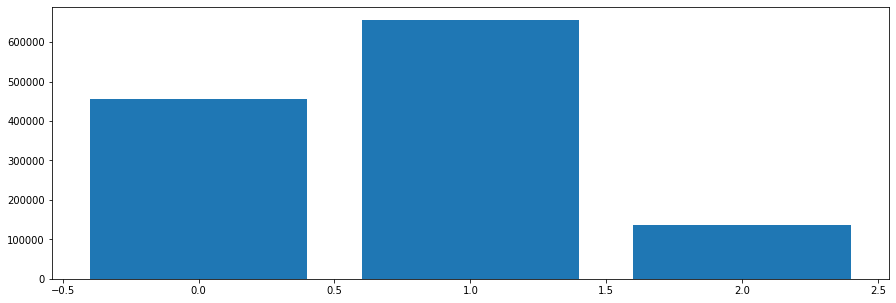

In [17]:
plt.figure(figsize=(15, 5))
plt.bar(df['Category'].value_counts().index.tolist(),df['Category'].value_counts())
plt.show()

On découvre l'attribut `Location Description` sous forme de `String` qui indique dans quel endroit s'est passé le crime.

On trouve 193 *Locations* différentes dans notre dataset

In [18]:
#Il y a 193 Location possibles, listées ci-dessous
print(df['Location Description'].value_counts().to_string())

STREET                                                   273469
RESIDENCE                                                189416
APARTMENT                                                169633
SIDEWALK                                                 122477
OTHER                                                     42118
SMALL RETAIL STORE                                        34233
RESTAURANT                                                30136
PARKING LOT/GARAGE(NON.RESID.)                            30033
ALLEY                                                     27792
DEPARTMENT STORE                                          24198
VEHICLE NON-COMMERCIAL                                    22031
RESIDENCE PORCH/HALLWAY                                   20222
RESIDENTIAL YARD (FRONT/BACK)                             19885
GROCERY FOOD STORE                                        17495
GAS STATION                                               16366
SCHOOL, PUBLIC, BUILDING                

On essaye de voir le nombre d'arrestation effectuées par catégorie :

In [19]:
df[['Arrest', 'Category']].groupby('Category').sum()

,Arrest
Category,
0,91221
1,53552
2,122627


La probabilité qu'une arrestation soit effectuée par catégorie :

In [20]:
df[['Arrest', 'Category']].groupby('Category').mean()

,Arrest
Category,
0,0.200547
1,0.081628
2,0.898781


Les différentes combinaisons pour `Beat`, `District`, `Ward` et `Community Area` :

In [21]:
df[['Beat', 'District', 'Ward', 'Community Area']].value_counts()

Beat  District  Ward  Community Area
1834  18.0      42.0  8.0               14667
111   1.0       42.0  32.0              10711
112   1.0       42.0  32.0              10271
1831  18.0      42.0  8.0               10264
421   4.0       7.0   43.0              10036
                                        ...  
1923  25.0      46.0  6.0                   1
735   6.0       17.0  67.0                  1
734   6.0       17.0  67.0                  1
412   22.0      8.0   48.0                  1
814   31.0      23.0  56.0                  1
Length: 1119, dtype: int64

In [22]:
df.head()

,Date,Category,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
13,01/01/2015 12:01:00 AM,2,RESIDENCE,False,False,221,2.0,3.0,38.0,2015,41.811212,-87.615663
15,01/01/2015 12:01:00 AM,1,ATHLETIC CLUB,False,False,1814,18.0,2.0,7.0,2015,41.911151,-87.635982
16,01/01/2015 12:01:00 AM,0,RESIDENCE,False,False,2532,25.0,37.0,25.0,2015,41.902203,-87.760110
17,01/01/2015 12:01:00 AM,0,RESIDENCE,False,False,925,9.0,3.0,37.0,2015,41.814283,-87.633512
18,01/01/2015 12:01:00 AM,0,RESIDENCE,False,False,1512,15.0,29.0,25.0,2015,41.888997,-87.770622


On aimerais ensuite nous occupé de l'attribut `Date` et de le rendre plus exploitable.

On en extrait alors les attributs `Day`, `Month` et `Hour` qui peuvent jouer un rôle important dans la prédiction de la catégorie du crime qui aura lieu selon le temps.

In [23]:
df.insert(9, "Day", df['Date'].str.split('/', 2, expand=True)[1])
df.loc[:,'Day'] = pd.to_numeric(df.loc[:,'Day'])
df.insert(10, "Month", df['Date'].str.split('/', 1, expand=True)[0])
df.loc[:,'Month'] = pd.to_numeric(df.loc[:,'Month'])

In [24]:
tmp = df['Date'].str.split(' ', 2, expand=True)
tmp.insert(1, "Hour", pd.to_numeric(tmp[1].str.split(':', 1, expand=True)[0]))
tmp.loc[tmp[2] == "PM", 'Hour'] += 12
tmp.loc[tmp['Hour'] == 24, 'Hour'] = 0
df.insert(9, "Hour", tmp['Hour'])
df

,Date,Category,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Hour,Day,Month,Year,Latitude,Longitude
13,01/01/2015 12:01:00 AM,2,RESIDENCE,False,False,221,2.0,3.0,38.0,12,1,1,2015,41.811212,-87.615663
15,01/01/2015 12:01:00 AM,1,ATHLETIC CLUB,False,False,1814,18.0,2.0,7.0,12,1,1,2015,41.911151,-87.635982
16,01/01/2015 12:01:00 AM,0,RESIDENCE,False,False,2532,25.0,37.0,25.0,12,1,1,2015,41.902203,-87.760110
17,01/01/2015 12:01:00 AM,0,RESIDENCE,False,False,925,9.0,3.0,37.0,12,1,1,2015,41.814283,-87.633512
18,01/01/2015 12:01:00 AM,0,RESIDENCE,False,False,1512,15.0,29.0,25.0,12,1,1,2015,41.888997,-87.770622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584342,03/29/2021 11:35:00 PM,2,STREET,True,False,2533,25.0,37.0,25.0,23,29,3,2021,41.912013,-87.745929
1584343,03/29/2021 11:45:00 PM,0,STREET,True,True,822,8.0,14.0,63.0,23,29,3,2021,41.795251,-87.709642
1584344,03/29/2021 11:45:00 PM,0,SIDEWALK,True,False,1831,18.0,42.0,8.0,23,29,3,2021,41.889761,-87.627999
1584345,03/29/2021 11:45:00 PM,0,APARTMENT,False,True,1931,19.0,32.0,7.0,23,29,3,2021,41.929029,-87.672011


On drop la colonne `Date`

In [25]:
df = df.drop('Date', axis=1)

On transforme les colonne `Arrest` et `Domestic` booléennes en des entier (0 pour False et 1 pour True)

In [26]:
df['Arrest'] = df['Arrest'].astype(int)
df['Domestic'] = df['Domestic'].astype(int)

N'ayant pas cherché une meilleure manière pour exploiter l'attribut `Location Description`, on a décidé de simplement l'encoder avec un `OrdinalEncoder()`

In [27]:
# Numeriser 'Location Description'
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df['Location Description'] = enc.fit_transform(df[['Location Description']])

On mélange notre jeu de données

In [28]:
df = df.sample(frac=1)
df

,Category,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Hour,Day,Month,Year,Latitude,Longitude
1057342,0,89.0,0,0,712,7.0,16.0,68.0,0,12,12,2018,41.787017,-87.645506
1352020,0,24.0,0,0,1925,19.0,46.0,6.0,18,1,2,2020,41.949954,-87.649572
922407,1,148.0,0,0,113,1.0,42.0,32.0,13,19,6,2018,41.879236,-87.624347
3889,0,94.0,0,0,422,4.0,7.0,46.0,21,6,1,2015,41.751816,-87.560005
370424,0,147.0,1,0,1115,11.0,28.0,26.0,20,31,5,2016,41.878856,-87.726672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450778,0,133.0,0,0,2533,25.0,37.0,25.0,21,8,9,2016,41.909604,-87.747667
76787,2,167.0,1,0,922,9.0,12.0,61.0,19,25,4,2015,41.808419,-87.684047
1301102,1,74.0,0,0,1924,19.0,44.0,6.0,0,16,11,2019,41.940669,-87.655347
690010,1,125.0,0,0,2532,25.0,37.0,25.0,0,1,8,2017,41.903118,-87.759231


La matrice de corrélation ci-dessous nous montre que les attributs `Beat`, `District`, `Ward` et `Community Area` sont très corrélés (positivement ou négativement), corrélés aussi avec la `Latitude` et la `Longitude`.

Ceci est normal comme ce sont tous des attributs qui représentent un emplacement sur la carte :

**TL;DR**:
* Beat : Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
* Disctrict : Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r. (Chicago compte 22 districts de police).
* Ward : The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
* Community Area : Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

(Source : https://www.kaggle.com/chicago/chicago-crime)

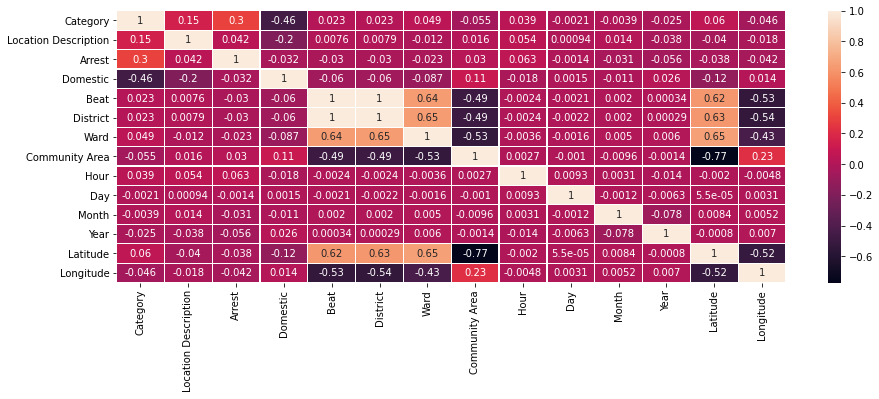

In [29]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(data = corr_matrix, annot=True, linewidths=0.2)
plt.show()

On a choisi de garder l'attribut `District` qui possède 22 valeurs différentes, et de supprimer les autres attributs qui portent des informations similaires.

In [30]:
df.drop(columns = ['Beat', 'Ward', 'Community Area'], inplace = True)
df.reset_index(drop=True, inplace=True)
df

,Category,Location Description,Arrest,Domestic,District,Hour,Day,Month,Year,Latitude,Longitude
0,0,89.0,0,0,7.0,0,12,12,2018,41.787017,-87.645506
1,0,24.0,0,0,19.0,18,1,2,2020,41.949954,-87.649572
2,1,148.0,0,0,1.0,13,19,6,2018,41.879236,-87.624347
3,0,94.0,0,0,4.0,21,6,1,2015,41.751816,-87.560005
4,0,147.0,1,0,11.0,20,31,5,2016,41.878856,-87.726672
...,...,...,...,...,...,...,...,...,...,...,...
1247339,0,133.0,0,0,25.0,21,8,9,2016,41.909604,-87.747667
1247340,2,167.0,1,0,9.0,19,25,4,2015,41.808419,-87.684047
1247341,1,74.0,0,0,19.0,0,16,11,2019,41.940669,-87.655347
1247342,1,125.0,0,0,25.0,0,1,8,2017,41.903118,-87.759231


On obtient alors la matrice de corrélation suivant :

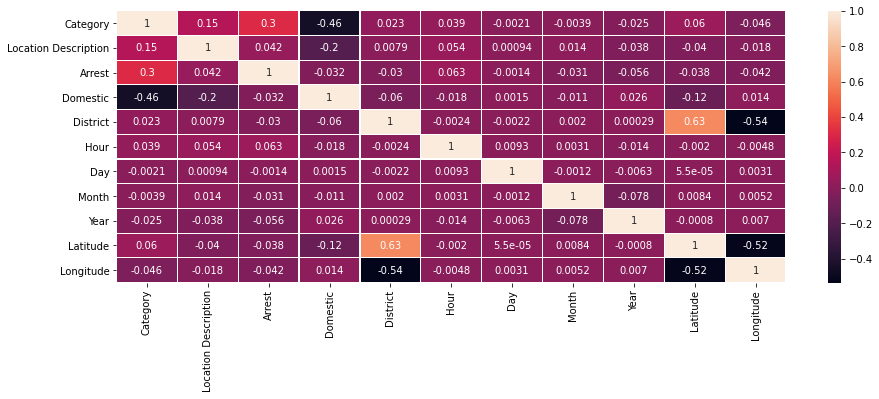

In [31]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(data = corr_matrix, annot=True, linewidths=0.2)
plt.show()

Avant de commencer la modélisation, et sachant que certains modèles nécessitent de garder le jeu de données, on sait qu'avec notre jeu de données avec plus de **1.5 million** d'exemples, certains modèles metteront une éternité pour s'entaîner avec nos simples ordinateurs limités par les ressources.

On a donc décidé de travailler sur un échantillon (de 20 000 lignes) du dataset d'origine qui soit le plus représentatif que possible du dataset initial.

On utilise la fonction `sample` pour échantillonner. Puis on fait appel au *test de Kolmogorov-Smirnov* pour vérifier que l'échantillonnage nous a pas fait perdre des données significatives.

Pour vérifier cela, il faut que les `pvalues` soient toutes au moins supérieures à 5% (0.05).

Pour plus de détails, lire la documentation de `ks_2samp` de `scipy`.

In [32]:
from scipy.stats import ks_2samp

sample_size = 20000
subsample = df.sample(sample_size, axis = 0, random_state=1)
pvalues = [None for _ in range(df.shape[1])]
for col in range(df.shape[1]) :
    # Using Kolmogorov-Smirnov test to check whether the sample truely represents the original dataset
    _, pvalues[col] = ks_2samp(df.iloc[:,col], subsample.iloc[:,col])

pvalues

[0.9991564221798757,
 0.5142266183552056,
 0.9966942362039569,
 0.9999999998727649,
 0.7585368527272978,
 0.8509611576281594,
 0.8275199887928899,
 0.39384224332337325,
 0.9999999999642781,
 0.6304493377224243,
 0.09910468690107133]

On garde notre DataFrame originale dans `df_legacy` et l'échantillon dans `df`

In [33]:
df_legacy = df
df = subsample
df.reset_index(drop=True, inplace=True)

On vérifie que la matrice de corrélation pour l'échantillon est identique à celle du dataset d'origine.

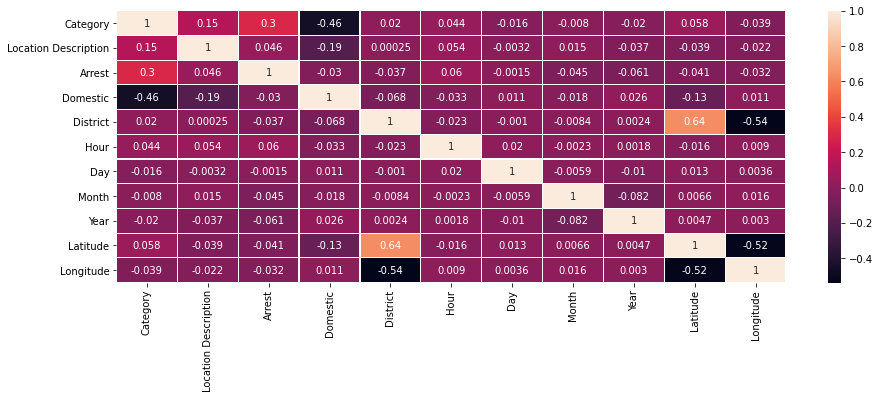

In [34]:
corr_matrix = df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(data = corr_matrix, annot=True, linewidths=0.2)
plt.show()

Et que la distribution des exemples par catégories est toujours respectée.

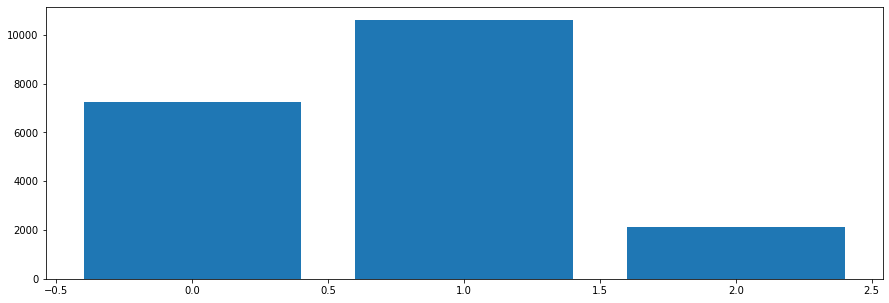

In [35]:
plt.figure(figsize=(15, 5))
plt.bar(df['Category'].value_counts().index.tolist(),df['Category'].value_counts())
plt.show()

On sépare l'attribut qu'on aimerait prédire et qui contient les 3 classes du dataset et on le met dans la variable `y`, et le reste des attributs dans la variable `X`.

On fait de la **classification multiclasses**

In [36]:
X = df.drop('Category', axis=1)
y = df['Category']

On crée le jeu d'entraînement (train set : 70%) et le jeu de test (test set : 30%) :

In [37]:
# Création de l'ensemble d'entrainement et de l'ensemble de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3, random_state = 1)

On standardize nos attributs grâce à un `StandardScaler` pour améliorer les performances lors de l'entraînement et éviter les problèmes numériques lors du calcul des gradients et de l'optimisation des fonctions objectif. (ne pas avoir les attributs sur des plages très différentes)

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 3. Modélisation :

On passe maintenant à l'étape de modélisation. On crée différents *classifiers* (modèles pour classification multiclasses) et on compare leurs performances pour choisir le meilleur d'entre eux.

### 3.1 KNN :

On commence par un modèle de type K Nearest Neighbor.

On choisit l'hyperparamètre `n_neighbors` optimal avec `GridSearchCV` comme vu en cours.

On a préféré utiliser le score `f1_weighted` (f1 score pondéré par les proportions des classes dans notre dataset) pour tous nos modèles puisque c'est un score qui représente mieux la performance lors d'une classification multiclasses avec un jeu de données non équilibré (c'est notre cas).

In [39]:
# Utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins)
# sur le jeu d’entraînement 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score


# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[13, 15, 17, 19, 21, 23, 25, 27, 29, 31]}


# Choisir un score à optimiser, ici f1-score pondéré (plus significatif que l'accuracy surtout en multiclass)
score = 'f1_weighted'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv = 5,
    verbose = 1,
    scoring = score
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_results = knn_grid.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [40]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Best parameters : {}".format(knn_grid.best_params_))
print("Best cross-validation score : {:.2f}".format(knn_grid.best_score_))

Best parameters : {'n_neighbors': 27}
Best cross-validation score : 0.71


In [41]:
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        knn_grid.cv_results_['mean_test_score'], # score moyen
        knn_grid.cv_results_['std_test_score'],  # écart-type du score
        knn_grid.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
f1_weighted = 0.707 (+/-0.013) for {'n_neighbors': 13}
f1_weighted = 0.709 (+/-0.008) for {'n_neighbors': 15}
f1_weighted = 0.709 (+/-0.010) for {'n_neighbors': 17}
f1_weighted = 0.711 (+/-0.012) for {'n_neighbors': 19}
f1_weighted = 0.711 (+/-0.012) for {'n_neighbors': 21}
f1_weighted = 0.711 (+/-0.013) for {'n_neighbors': 23}
f1_weighted = 0.711 (+/-0.015) for {'n_neighbors': 25}
f1_weighted = 0.713 (+/-0.016) for {'n_neighbors': 27}
f1_weighted = 0.712 (+/-0.016) for {'n_neighbors': 29}
f1_weighted = 0.712 (+/-0.016) for {'n_neighbors': 31}


**Efficacité moyenne du modèle par cross-validation (validation croisée)**

On utilise la fonction `cross-validate` vue en cours avec des scores adaptés au cas multiclass :
* précision pondérée
* rappel pondéré
* balanced accuracy
* f1 score pondéré
* roc auc avec du one vs rest et de la pondération

(Détails dans **sklearn.metrics**)

In [42]:
from sklearn.model_selection import cross_validate
scores_knn = cross_validate(knn_grid, X_train, y_train, cv=5,
            scoring=('precision_weighted','recall_weighted','balanced_accuracy','f1_weighted','roc_auc_ovr_weighted'))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


On affiche la performance de ce modèle : (71.2%)

In [43]:
print("Cross-validation performance : {:.3f}".format(scores_knn['test_f1_weighted'].mean()))

Cross-validation performance : 0.712


### 3.2 Random Forest :

On passe à un modèle de type Random Forest.

On choisit les hyperparamètre `n_estimators` et `max_depth` optimaux avec cette fois `RandomizedSearchCV`.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
 'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)],
 'max_depth': [int(x) for x in np.linspace(20, 100, num = 5)]
 }
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(),
                               param_distributions = random_grid,
                               n_iter=50,
                               cv=5,
                               verbose=2,
                               random_state=1,
                               scoring='f1_weighted',
                               n_jobs=-1)
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [20, 40, 60, 80, 100],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=1, scoring='f1_weighted', verbose=2)

In [45]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Best parameters : {}".format(rf_random.best_params_))
print("Best cross-validation score : {:.2f}".format(rf_random.best_score_))

Best parameters : {'n_estimators': 120, 'max_depth': 80}
Best cross-validation score : 0.74


In [46]:
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        rf_random.cv_results_['mean_test_score'], # score moyen
        rf_random.cv_results_['std_test_score'],  # écart-type du score
        rf_random.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
f1_weighted = 0.729 (+/-0.009) for {'n_estimators': 20, 'max_depth': 20}
f1_weighted = 0.731 (+/-0.013) for {'n_estimators': 40, 'max_depth': 20}
f1_weighted = 0.735 (+/-0.017) for {'n_estimators': 60, 'max_depth': 20}
f1_weighted = 0.736 (+/-0.014) for {'n_estimators': 80, 'max_depth': 20}
f1_weighted = 0.734 (+/-0.014) for {'n_estimators': 100, 'max_depth': 20}
f1_weighted = 0.734 (+/-0.012) for {'n_estimators': 120, 'max_depth': 20}
f1_weighted = 0.734 (+/-0.015) for {'n_estimators': 140, 'max_depth': 20}
f1_weighted = 0.734 (+/-0.012) for {'n_estimators': 160, 'max_depth': 20}
f1_weighted = 0.736 (+/-0.011) for {'n_estimators': 180, 'max_depth': 20}
f1_weighted = 0.734 (+/-0.017) for {'n_estimators': 200, 'max_depth': 20}
f1_weighted = 0.726 (+/-0.020) for {'n_estimators': 20, 'max_depth': 40}
f1_weighted = 0.730 (+/-0.014) for {'n_estimators': 40, 'max_depth': 40}
f1_weighted = 0.733 (+/-0.009) for {'n_estimators': 60, 'max_depth': 40}
f1_weigh

**Calcul de l'efficacité moyenne du modèle par cross-validation (validation croisée)**

Puis on l'affiche : (73.4%)

In [47]:
scores_rf_random = cross_validate(rf_random, X_train, y_train, cv=5,
                    scoring=('precision_weighted','recall_weighted','balanced_accuracy','f1_weighted','roc_auc_ovr_weighted'))
print("Cross-validation performance : {:.3f}".format(scores_rf_random['test_f1_weighted'].mean()))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Cross-validation performance : 0.734


Comme attendu, le modèle Random Forest fait un peu mieux qu'un KNN.

### 3.3 XGBoost :

On passe maintenant à un modèle très connu par son efficacité : **XGBoost**.

Le modèle possède un bon nombre d'hyperparamètres, on choisit la meilleure combinaison entre certains d'entre eux pour les valeurs qu'on a donnée dans le dictionnaire `param_dist`, on utilise encore une fois `RandomizedSearchCV`.

On utilise aussi cette fois un objet `KFold` pour choisir le nombre de plis sur nos données d'entraînement qu'on va utiliser pour la validation croisée dans `RandomizedSearchCV`.

La **fonction objectif** qu'on spécifie pour le classifier dans notre cas multiclass est *'multi:softmax'*. Le **scoring** toujours avec du *'f1_weighted'*. Enfin, la **métrique d'évalution** (eval_metric) dans la fonction `fit` est le *'multi log loss'* (fonction de perte).

In [48]:
import xgboost as xgb

In [49]:
from scipy import stats
from sklearn.model_selection import KFold

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax')
param_dist = {'n_estimators': [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)],
              'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
              'subsample': (0.9 - 0.3) * random.random_sample(3)+ 0.3,
              'max_depth': [int(x) for x in np.linspace(20, 100, num = 5)],
              'colsample_bytree': (0.9 - 0.5) * random.random_sample(3) + 0.5
             }

numFolds = 5
kfold_5 = KFold(random_state=1, shuffle = True, n_splits = numFolds)

xgb_random = RandomizedSearchCV(xgb_clf, 
                         param_distributions = param_dist,
                         cv = kfold_5,
                         n_iter = 50,
                         scoring = 'f1_weighted', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

In [50]:
xgb_random.fit(X_train,y_train, eval_metric='mlogloss')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                   error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=No...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.86918892,

In [51]:
# Afficher le(s) hyperparamètre(s) optimaux
print("Best parameters : {}".format(xgb_random.best_params_))
print("Best cross-validation score : {:.2f}".format(xgb_random.best_score_))

Best parameters : {'subsample': 0.49568248279310045, 'n_estimators': 100, 'max_depth': 80, 'learning_rate': 0.001, 'colsample_bytree': 0.8691889161717675}
Best cross-validation score : 0.74


In [52]:
# Afficher les performances correspondante
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        xgb_random.cv_results_['mean_test_score'], # score moyen
        xgb_random.cv_results_['std_test_score'],  # écart-type du score
        xgb_random.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Résultats de la validation croisée :
f1_weighted = 0.729 (+/-0.011) for {'subsample': 0.7627155014500968, 'n_estimators': 80, 'max_depth': 40, 'learning_rate': 0.01, 'colsample_bytree': 0.559635577743145}
f1_weighted = 0.738 (+/-0.016) for {'subsample': 0.4277045805192762, 'n_estimators': 180, 'max_depth': 40, 'learning_rate': 0.001, 'colsample_bytree': 0.8691889161717675}
f1_weighted = 0.735 (+/-0.016) for {'subsample': 0.7627155014500968, 'n_estimators': 20, 'max_depth': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.8691889161717675}
f1_weighted = 0.736 (+/-0.016) for {'subsample': 0.4277045805192762, 'n_estimators': 100, 'max_depth': 80, 'learning_rate': 0.003, 'colsample_bytree': 0.7582357629850743}
f1_weighted = 0.734 (+/-0.021) for {'subsample': 0.7627155014500968, 'n_estimators': 40, 'max_depth': 80, 'learning_rate': 0.1, 'colsample_bytree': 0.7582357629850743}
f1_weighted = 0.735 (+/-0.013) for {'subsample': 0.4277045805192762, 'n_estimators': 20, 'max_depth': 60, 'learning_r

**Calcul de l'efficacité moyenne du modèle par cross-validation (validation croisée)**

Puis on l'affiche : (73.5%)

Le warning s'affiche car `cross_validate` appelle la fonction `fit` du classifier `xgb_random` sans lui passer `eval_metric = 'mlogloss'` comme paramètre.

In [53]:
scores_xgb_random = cross_validate(xgb_random, X_train, y_train, cv=3,
                    scoring=('precision_weighted','recall_weighted','balanced_accuracy','f1_weighted','roc_auc_ovr_weighted'))
print("Cross-validation performance : {:.3f}".format(scores_xgb_random['test_f1_weighted'].mean()))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[03:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[03:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[03:42:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:so

Le modèle XGBoost ne fait presque pas mieux qu'un modèle Random Forest. Il se peut que les hyperparamètres nécessitent plus de tuning, ou qu'il faut plus de données (mais pour entraîner ce modèle il nous faut déjà environ 15 minutes avec nos capacités computationnelles) ou que le modèle trouve du mal à approcher la fonction de décision car les données sont proches et qu'il risque l'**overfitting**.

## 3.4 Artificial Neural Network :

On essaye maintenant un **réseau de neurones artificiel** en espérant avoir de meilleures performances (on avait implémenté un Logistic Regressor avant de passer au réseau de neurones mais il n'a pas fait mieux que le KNN, on a donc supprimé les cellules).

Il faudrait avoir la bibliothèque `Keras` installée sur sa machine pour pouvoir exécuter les cellules suivantes.

On utilise un réseau de neurones avec deux *hidden layers* avec des outputs de 16 et 32 dimensions respectivement avec comme fonction d'ativation **relu**, suivies de la dernière couche (output layer) avec du **softmax** comme c'est du multiclasses.

On a dû implémenter une fonction `f1_weighted` pour la passer comme paramètre en tant que `metric` à la fonction `compile` du model.

On crée ensuite un **wrapper** sklearn autour de notre modèle Keras. On l'entraîne sur notre jeu de données puis on lui applique de la validation croisée.

Les hyperparamètres comme le *nombre d'epochs*, *batch_size*, le nombre de *hidden layers*, le *nombre de neurones dans chaque layer* etc. ne sont pas tunés comme il est fastidieux de retrouver les bons paramètres.

In [59]:
from keras import backend as K

def f1_weighted(true, pred):

    predLabels = K.argmax(pred, axis=-1)
    pred = K.one_hot(predLabels, 1) 


    ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
    weighted_f1 = K.sum(weighted_f1)

    
    return 1 - weighted_f1

In [75]:
from keras.layers import InputLayer
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

def baseline_model():
    model = Sequential()
    model.add(Dense(16, input_dim=10, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_weighted, 'accuracy'])
    return model

In [76]:
ann = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=200)

In [77]:
#Execution du modèle
ann.fit(X_train, y_train, epochs=200, batch_size=200)

Epoch 1/200
70/70 [==============================] - 1s 1ms/step - loss: 1.0474 - f1_weighted: 0.7905 - accuracy: 0.4789
Epoch 2/200
70/70 [==============================] - 0s 1ms/step - loss: 0.7486 - f1_weighted: 0.7537 - accuracy: 0.6937
Epoch 3/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6761 - f1_weighted: 0.7657 - accuracy: 0.7179
Epoch 4/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6567 - f1_weighted: 0.7657 - accuracy: 0.7210
Epoch 5/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6525 - f1_weighted: 0.7645 - accuracy: 0.7233
Epoch 6/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6550 - f1_weighted: 0.7672 - accuracy: 0.7252
Epoch 7/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6315 - f1_weighted: 0.7615 - accuracy: 0.7331
Epoch 8/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6416 - f1_weighted: 0.7628 - accuracy: 0.7269
Epoch 9/200
70/70 [=============

70/70 [==============================] - 0s 1ms/step - loss: 0.5979 - f1_weighted: 0.7658 - accuracy: 0.7481
Epoch 69/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6057 - f1_weighted: 0.7570 - accuracy: 0.7439
Epoch 70/200
70/70 [==============================] - 0s 1ms/step - loss: 0.5966 - f1_weighted: 0.7618 - accuracy: 0.7462
Epoch 71/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6040 - f1_weighted: 0.7659 - accuracy: 0.7481
Epoch 72/200
70/70 [==============================] - 0s 1ms/step - loss: 0.5982 - f1_weighted: 0.7666 - accuracy: 0.7494
Epoch 73/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6093 - f1_weighted: 0.7626 - accuracy: 0.7430
Epoch 74/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6037 - f1_weighted: 0.7596 - accuracy: 0.7425
Epoch 75/200
70/70 [==============================] - 0s 1ms/step - loss: 0.5954 - f1_weighted: 0.7639 - accuracy: 0.7476
Epoch 76/200
70/70 [=================

70/70 [==============================] - 0s 1ms/step - loss: 0.6047 - f1_weighted: 0.7619 - accuracy: 0.7375
Epoch 135/200
70/70 [==============================] - 0s 1ms/step - loss: 0.5948 - f1_weighted: 0.7596 - accuracy: 0.7460
Epoch 136/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6012 - f1_weighted: 0.7552 - accuracy: 0.7421
Epoch 137/200
70/70 [==============================] - 0s 1ms/step - loss: 0.5951 - f1_weighted: 0.7540 - accuracy: 0.7446
Epoch 138/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6049 - f1_weighted: 0.7522 - accuracy: 0.7399
Epoch 139/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6029 - f1_weighted: 0.7569 - accuracy: 0.7419
Epoch 140/200
70/70 [==============================] - 0s 1ms/step - loss: 0.6017 - f1_weighted: 0.7564 - accuracy: 0.7402
Epoch 141/200
70/70 [==============================] - 0s 1ms/step - loss: 0.5962 - f1_weighted: 0.7572 - accuracy: 0.7453
Epoch 142/200
70/70 [=========

70/70 [==============================] - 0s 1ms/step - loss: 0.5783 - f1_weighted: 0.7519 - accuracy: 0.7555


In [78]:
scores_ann = cross_validate(ann, X_train, y_train, cv=5,
                    scoring=('precision_weighted','recall_weighted','balanced_accuracy','f1_weighted','roc_auc_ovr_weighted'))

Epoch 1/200
56/56 [==============================] - 1s 1ms/step - loss: 1.1104 - f1_weighted: 0.4679 - accuracy: 0.3907
Epoch 2/200
56/56 [==============================] - 0s 1ms/step - loss: 0.8004 - f1_weighted: 0.7455 - accuracy: 0.6773
Epoch 3/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6966 - f1_weighted: 0.7634 - accuracy: 0.7120
Epoch 4/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6750 - f1_weighted: 0.7631 - accuracy: 0.7147
Epoch 5/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6549 - f1_weighted: 0.7635 - accuracy: 0.7257
Epoch 6/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6381 - f1_weighted: 0.7615 - accuracy: 0.7337
Epoch 7/200
56/56 [==============================] - 0s 853us/step - loss: 0.6480 - f1_weighted: 0.7683 - accuracy: 0.7220
Epoch 8/200
56/56 [==============================] - 0s 971us/step - loss: 0.6414 - f1_weighted: 0.7613 - accuracy: 0.7280
Epoch 9/200
56/56 [=========

56/56 [==============================] - 0s 1ms/step - loss: 0.6119 - f1_weighted: 0.7567 - accuracy: 0.7394
Epoch 68/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6074 - f1_weighted: 0.7693 - accuracy: 0.7425
Epoch 69/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6034 - f1_weighted: 0.7648 - accuracy: 0.7394
Epoch 70/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6014 - f1_weighted: 0.7603 - accuracy: 0.7420
Epoch 71/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6091 - f1_weighted: 0.7551 - accuracy: 0.7404
Epoch 72/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6070 - f1_weighted: 0.7609 - accuracy: 0.7415
Epoch 73/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6051 - f1_weighted: 0.7626 - accuracy: 0.7414
Epoch 74/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6113 - f1_weighted: 0.7618 - accuracy: 0.7389
Epoch 75/200
56/56 [=================

56/56 [==============================] - 0s 1ms/step - loss: 0.5958 - f1_weighted: 0.7425 - accuracy: 0.7431
Epoch 134/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5960 - f1_weighted: 0.7444 - accuracy: 0.7445
Epoch 135/200
56/56 [==============================] - 0s 853us/step - loss: 0.5943 - f1_weighted: 0.7548 - accuracy: 0.7475
Epoch 136/200
56/56 [==============================] - 0s 971us/step - loss: 0.5938 - f1_weighted: 0.7520 - accuracy: 0.7438
Epoch 137/200
56/56 [==============================] - 0s 853us/step - loss: 0.5898 - f1_weighted: 0.7535 - accuracy: 0.7485
Epoch 138/200
56/56 [==============================] - 0s 971us/step - loss: 0.5947 - f1_weighted: 0.7542 - accuracy: 0.7491
Epoch 139/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5896 - f1_weighted: 0.7399 - accuracy: 0.7471
Epoch 140/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5933 - f1_weighted: 0.7499 - accuracy: 0.7425
Epoch 141/200
56/56 [=

56/56 [==============================] - 0s 971us/step - loss: 0.5927 - f1_weighted: 0.7481 - accuracy: 0.7471
Epoch 200/200
56/56 [==============================] - 0s 971us/step - loss: 0.5867 - f1_weighted: 0.7446 - accuracy: 0.7477


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/200
56/56 [==============================] - 1s 1ms/step - loss: 1.1234 - f1_weighted: 0.8051 - accuracy: 0.3654
Epoch 2/200
56/56 [==============================] - 0s 971us/step - loss: 0.8607 - f1_weighted: 0.7267 - accuracy: 0.6213
Epoch 3/200
56/56 [==============================] - 0s 1ms/step - loss: 0.7268 - f1_weighted: 0.7530 - accuracy: 0.7044
Epoch 4/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6637 - f1_weighted: 0.7501 - accuracy: 0.7243
Epoch 5/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6519 - f1_weighted: 0.7517 - accuracy: 0.7245
Epoch 6/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6515 - f1_weighted: 0.7585 - accuracy: 0.7237
Epoch 7/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6463 - f1_weighted: 0.7618 - accuracy: 0.7249
Epoch 8/200
56/56 [==============================] - 0s 971us/step - loss: 0.6391 - f1_weighted: 0.7610 - accuracy: 0.7273
Epoch 9/200
56/56 [=========

56/56 [==============================] - 0s 1ms/step - loss: 0.6067 - f1_weighted: 0.7540 - accuracy: 0.7387
Epoch 69/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5993 - f1_weighted: 0.7539 - accuracy: 0.7420
Epoch 70/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5988 - f1_weighted: 0.7563 - accuracy: 0.7419
Epoch 71/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5917 - f1_weighted: 0.7599 - accuracy: 0.7462
Epoch 72/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5986 - f1_weighted: 0.7577 - accuracy: 0.7469
Epoch 73/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5998 - f1_weighted: 0.7597 - accuracy: 0.7409
Epoch 74/200
56/56 [==============================] - 0s 991us/step - loss: 0.5931 - f1_weighted: 0.7527 - accuracy: 0.7464
Epoch 75/200
56/56 [==============================] - 0s 944us/step - loss: 0.5963 - f1_weighted: 0.7552 - accuracy: 0.7480
Epoch 76/200
56/56 [=============

56/56 [==============================] - 0s 1ms/step - loss: 0.6017 - f1_weighted: 0.7508 - accuracy: 0.7450
Epoch 135/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5955 - f1_weighted: 0.7514 - accuracy: 0.7474
Epoch 136/200
56/56 [==============================] - 0s 971us/step - loss: 0.5702 - f1_weighted: 0.7477 - accuracy: 0.7566
Epoch 137/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5894 - f1_weighted: 0.7529 - accuracy: 0.7501
Epoch 138/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5977 - f1_weighted: 0.7508 - accuracy: 0.7445
Epoch 139/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5975 - f1_weighted: 0.7498 - accuracy: 0.7459
Epoch 140/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5874 - f1_weighted: 0.7446 - accuracy: 0.7497
Epoch 141/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5847 - f1_weighted: 0.7406 - accuracy: 0.7504
Epoch 142/200
56/56 [=======

56/56 [==============================] - 0s 1ms/step - loss: 0.5883 - f1_weighted: 0.7369 - accuracy: 0.7446


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/200
56/56 [==============================] - 1s 1ms/step - loss: 1.1270 - f1_weighted: 0.9806 - accuracy: 0.3625
Epoch 2/200
56/56 [==============================] - 0s 1ms/step - loss: 0.8672 - f1_weighted: 0.8166 - accuracy: 0.6037
Epoch 3/200
56/56 [==============================] - 0s 1ms/step - loss: 0.7777 - f1_weighted: 0.7586 - accuracy: 0.6627
Epoch 4/200
56/56 [==============================] - 0s 1ms/step - loss: 0.7193 - f1_weighted: 0.7325 - accuracy: 0.6836
Epoch 5/200
56/56 [==============================] - 0s 971us/step - loss: 0.6864 - f1_weighted: 0.7448 - accuracy: 0.7012
Epoch 6/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6668 - f1_weighted: 0.7549 - accuracy: 0.7128
Epoch 7/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6538 - f1_weighted: 0.7488 - accuracy: 0.7197
Epoch 8/200
56/56 [==============================] - 0s 971us/step - loss: 0.6543 - f1_weighted: 0.7646 - accuracy: 0.7197
Epoch 9/200
56/56 [=========

Epoch 68/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6043 - f1_weighted: 0.7457 - accuracy: 0.7361
Epoch 69/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5994 - f1_weighted: 0.7540 - accuracy: 0.7401
Epoch 70/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6143 - f1_weighted: 0.7602 - accuracy: 0.7337
Epoch 71/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5996 - f1_weighted: 0.7599 - accuracy: 0.7374
Epoch 72/200
56/56 [==============================] - 0s 2ms/step - loss: 0.6087 - f1_weighted: 0.7536 - accuracy: 0.7355
Epoch 73/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6032 - f1_weighted: 0.7518 - accuracy: 0.7375
Epoch 74/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5967 - f1_weighted: 0.7531 - accuracy: 0.7437
Epoch 75/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6106 - f1_weighted: 0.7566 - accuracy: 0.7353
Epoch 76/200
56/56 [====

56/56 [==============================] - 0s 1ms/step - loss: 0.6008 - f1_weighted: 0.7433 - accuracy: 0.7348
Epoch 135/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6113 - f1_weighted: 0.7401 - accuracy: 0.7310
Epoch 136/200
56/56 [==============================] - 0s 971us/step - loss: 0.5971 - f1_weighted: 0.7487 - accuracy: 0.7390
Epoch 137/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5890 - f1_weighted: 0.7551 - accuracy: 0.7477
Epoch 138/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6063 - f1_weighted: 0.7389 - accuracy: 0.7298
Epoch 139/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5934 - f1_weighted: 0.7454 - accuracy: 0.7445
Epoch 140/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5900 - f1_weighted: 0.7478 - accuracy: 0.7378
Epoch 141/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5927 - f1_weighted: 0.7444 - accuracy: 0.7420
Epoch 142/200
56/56 [=======

56/56 [==============================] - 0s 1ms/step - loss: 0.5838 - f1_weighted: 0.7335 - accuracy: 0.7502
Epoch 200/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5890 - f1_weighted: 0.7448 - accuracy: 0.7443


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/200
56/56 [==============================] - 1s 1ms/step - loss: 1.3193 - f1_weighted: 0.5857 - accuracy: 0.2709
Epoch 2/200
56/56 [==============================] - 0s 1ms/step - loss: 0.8757 - f1_weighted: 0.6880 - accuracy: 0.6179
Epoch 3/200
56/56 [==============================] - 0s 1ms/step - loss: 0.7390 - f1_weighted: 0.7258 - accuracy: 0.6921
Epoch 4/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6965 - f1_weighted: 0.7398 - accuracy: 0.7123
Epoch 5/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6624 - f1_weighted: 0.7512 - accuracy: 0.7246
Epoch 6/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6640 - f1_weighted: 0.7660 - accuracy: 0.7224
Epoch 7/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6591 - f1_weighted: 0.7636 - accuracy: 0.7214
Epoch 8/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6473 - f1_weighted: 0.7639 - accuracy: 0.7279
Epoch 9/200
56/56 [=============

56/56 [==============================] - 0s 1ms/step - loss: 0.6108 - f1_weighted: 0.7574 - accuracy: 0.7429
Epoch 69/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5955 - f1_weighted: 0.7678 - accuracy: 0.7473
Epoch 70/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5971 - f1_weighted: 0.7647 - accuracy: 0.7476
Epoch 71/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5936 - f1_weighted: 0.7596 - accuracy: 0.7498
Epoch 72/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5988 - f1_weighted: 0.7619 - accuracy: 0.7440
Epoch 73/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6011 - f1_weighted: 0.7544 - accuracy: 0.7443
Epoch 74/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5957 - f1_weighted: 0.7559 - accuracy: 0.7461
Epoch 75/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6077 - f1_weighted: 0.7590 - accuracy: 0.7426
Epoch 76/200
56/56 [=================

56/56 [==============================] - 0s 2ms/step - loss: 0.5975 - f1_weighted: 0.7508 - accuracy: 0.7443
Epoch 135/200
56/56 [==============================] - ETA: 0s - loss: 0.5885 - f1_weighted: 0.7465 - accuracy: 0.74 - 0s 1ms/step - loss: 0.5899 - f1_weighted: 0.7484 - accuracy: 0.7457
Epoch 136/200
56/56 [==============================] - 0s 2ms/step - loss: 0.5930 - f1_weighted: 0.7521 - accuracy: 0.7470
Epoch 137/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5874 - f1_weighted: 0.7452 - accuracy: 0.7441
Epoch 138/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5977 - f1_weighted: 0.7518 - accuracy: 0.7439
Epoch 139/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5959 - f1_weighted: 0.7504 - accuracy: 0.7431
Epoch 140/200
56/56 [==============================] - 0s 2ms/step - loss: 0.5982 - f1_weighted: 0.7498 - accuracy: 0.7451
Epoch 141/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5821 - f1_we

56/56 [==============================] - 0s 1ms/step - loss: 0.5876 - f1_weighted: 0.7441 - accuracy: 0.7495


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/200
56/56 [==============================] - 1s 1ms/step - loss: 1.0414 - f1_weighted: 0.4840 - accuracy: 0.4255
Epoch 2/200
56/56 [==============================] - 0s 853us/step - loss: 0.8238 - f1_weighted: 0.7159 - accuracy: 0.6526
Epoch 3/200
56/56 [==============================] - 0s 971us/step - loss: 0.7281 - f1_weighted: 0.7603 - accuracy: 0.6908
Epoch 4/200
56/56 [==============================] - 0s 971us/step - loss: 0.6767 - f1_weighted: 0.7615 - accuracy: 0.7156
Epoch 5/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6645 - f1_weighted: 0.7574 - accuracy: 0.7216
Epoch 6/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6443 - f1_weighted: 0.7655 - accuracy: 0.7310
Epoch 7/200
56/56 [==============================] - 0s 971us/step - loss: 0.6477 - f1_weighted: 0.7665 - accuracy: 0.7255
Epoch 8/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6525 - f1_weighted: 0.7663 - accuracy: 0.7229
Epoch 9/200
56/56 [=====

56/56 [==============================] - 0s 1ms/step - loss: 0.6080 - f1_weighted: 0.7573 - accuracy: 0.7379
Epoch 69/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6200 - f1_weighted: 0.7630 - accuracy: 0.7287
Epoch 70/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6040 - f1_weighted: 0.7606 - accuracy: 0.7385
Epoch 71/200
56/56 [==============================] - 0s 964us/step - loss: 0.6064 - f1_weighted: 0.7666 - accuracy: 0.7374
Epoch 72/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6117 - f1_weighted: 0.7622 - accuracy: 0.7393
Epoch 73/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6033 - f1_weighted: 0.7618 - accuracy: 0.7380
Epoch 74/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6082 - f1_weighted: 0.7608 - accuracy: 0.7386
Epoch 75/200
56/56 [==============================] - 0s 1ms/step - loss: 0.6078 - f1_weighted: 0.7546 - accuracy: 0.7311
Epoch 76/200
56/56 [===============

56/56 [==============================] - 0s 1ms/step - loss: 0.5950 - f1_weighted: 0.7470 - accuracy: 0.7418
Epoch 135/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5957 - f1_weighted: 0.7534 - accuracy: 0.7465
Epoch 136/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5921 - f1_weighted: 0.7528 - accuracy: 0.7461
Epoch 137/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5951 - f1_weighted: 0.7552 - accuracy: 0.7483
Epoch 138/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5906 - f1_weighted: 0.7528 - accuracy: 0.7451
Epoch 139/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5984 - f1_weighted: 0.7523 - accuracy: 0.7423
Epoch 140/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5923 - f1_weighted: 0.7548 - accuracy: 0.7479
Epoch 141/200
56/56 [==============================] - 0s 1ms/step - loss: 0.5941 - f1_weighted: 0.7488 - accuracy: 0.7424
Epoch 142/200
56/56 [=========

56/56 [==============================] - 0s 1ms/step - loss: 0.5841 - f1_weighted: 0.7468 - accuracy: 0.7476


c:\users\lenovo\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [79]:
print("Cross-validation performance : {:.3f}".format(scores_ann['test_f1_weighted'].mean()))

Cross-validation performance : 0.715


Le réseau de neurones n'est pas bien implémenté, il nécessite des modification pour être plus performant que les autres. On peut notamment utiliser tout le dataset original pour l'entraîner et avoir de meilleurs résultats.

## 4. Sélection de modèle :

Nous allons maintenant choisir le modèle avec la meilleure performance par cross-validation, qui est le modèle XGBoost.

In [80]:
model = xgb_random

## 5. Evaluation du modèle :

On évalue maintenant le modèle sélectionné sur le **Test Set**.

In [81]:
print("Test set score : {:.2f}".format(model.score(X_test, y_test)))

Test set score : 0.74


Le modèle nous donne un score de 74% sur le test set ce qui est un très bon début. Le modèle se généralise bien aux données qu'il n'a jamais vu.

### Rapport de classification et matrice de confusion :

Nous regardons ci-dessous que le modèle rencontre des difficultés à différencier les crimes de la catégorie ODATP de la catégorie ODAP et se trompe très souvent.

              precision    recall  f1-score   support

       ODATP       0.79      0.52      0.63      2204
        ODAP       0.74      0.91      0.82      3157
      OAPHSD       0.72      0.75      0.73       639

    accuracy                           0.75      6000
   macro avg       0.75      0.73      0.73      6000
weighted avg       0.76      0.75      0.74      6000



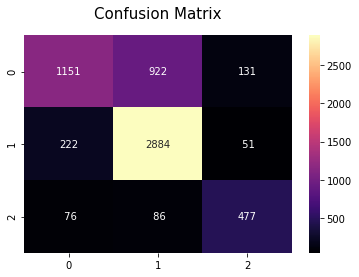

In [82]:
from sklearn import metrics

y_pred = model.predict(X_test)
target_names = ['ODATP', 'ODAP', 'OAPHSD']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True,fmt='3.0f',cmap='magma')
plt.title('Confusion Matrix', y=1.05, size=15)
plt.show()

Mais notre modèle reste quand même beaucoup plus performant qu'un *dummy classifier* qui prédit les classes uniformément.

In [86]:
from sklearn.dummy import DummyClassifier
dum = DummyClassifier(strategy='uniform', random_state=0)
dum = dum.fit(X_test, y_test)

Text(0.5, 1.0, 'matrice de confusion')

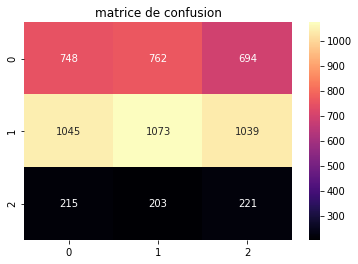

In [87]:
y_pred_dum = dum.predict(X_test)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_dum),annot=True,fmt='3.0f',cmap="magma")
plt.title('matrice de confusion')

## 6. Mise en production :

Nous pouvons à présent donner à notre modèle un 'Location Description' (codé selon le Ordinal Encoder), si une arrestation a eu lieu ou pas, si le crime est domestique, l'heure, le jour du mois, le mois, l'année et la latitude et la longitude et il va nous prédire la catégorie du crime qui se produira avec la fonction `predict()`.

In [ ]:
y_to_predict = []
model.predict(y_to_predict)
print(y_to_predict)